<a href="https://colab.research.google.com/github/wasnaqvi/colab_notebooks/blob/main/Bayesball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the BayesBall notebook.

This notebook serves as a gentle introduction to hierarchical modelling.





1. **Soccer (football)** – hierarchical goal-scoring rates with NumPyro  
2. **Baseball** – hierarchical batting averages with PyMC3  
3. **Toy HERMES-style exoplanet model** – a mass–metallicity relation with NumPyro
4. Line Intensity Map Stacking.

Each section includes sliders / widgets so you can poke the models yourselves!!
Run cells from top to bottom.


## A **very short** Introduction to Hierarchical Modeling

Hierarchical (or **multilevel**) modeling is a Bayesian framework for analyzing
data that naturally arise from **groups**, **populations**, or **units** that share
information. Instead of treating each unit independently (no pooling) or forcing
them all to be identical (complete pooling), hierarchical models blend the two
extremes through **partial pooling**.

At their core, hierarchical models assume that each unit — a player, a team,
a planet, a school, a star, a galaxy, etc. — has its own **true latent
parameter**, but these parameters themselves come from a **population-level
distribution**.

Example structure:

$\theta_i \sim \mathcal{N}(\mu,\; \tau^2)$

$y_i \sim p(y_i \mid \theta_i)$

Here:

- $\theta_i$ is the latent parameter for unit \(i\)  
  (e.g., a player's true scoring ability)

- $\mu$ and $\tau$ govern the **population distribution**  
  (e.g., average ability in the league and how much players vary)

- $y_i$ is the observed data  
  (e.g., goals, hits, metallicity measurements, etc.)

The hierarchical model therefore has **two levels**:

### **1. Population Level**
The model learns global quantities $\mu$ and $\tau$ that describe the
entire population. These encode general trends, such as:

- typical scoring ability across the league  
- typical batting ability across MLB  
- typical metallicity trend across exoplanets

### **2. Individual Level**
Each individual unit gets its own parameter $\theta_i$, but not estimated in
isolation — the model **shares strength across the dataset**, allowing better
estimation, especially when some units have limited data.

This gives rise to **Bayesian shrinkage**:

- units with **lots** of data stay close to their observed value  
- units with **little** data shrink toward the population mean $\mu$

This is mathematically optimal under the hierarchical prior and is one of the
main benefits of multilevel models.

### **Why hierarchical models?**

- They prevent overfitting to noisy or sparse observations.  
- They produce **fair comparisons** between units by adjusting for context  
  (e.g., minutes played, age, sample size, measurement uncertainty).
- They reveal population-wide structure while still modeling individuals.  
- They reflect how scientists and humans think about uncertainty:  
  we always believe individuals are *similar but not identical*.

In this notebook, we will apply hierarchical models to:

1. **Soccer (Premier League 23–24)** → latent scoring ability with age adjustment  
2. **Baseball** → shrinkage of batting averages  
3. **Exoplanets** → population-level mass–metallicity trends
4. **Line Intensity Map** Stacking

Hierarchical Bayesian modeling gives you a bottom up view of data.


We will now do start with **Premier League 23–24** data.


In [ ]:
# Run this first to ensure you have all the dependecies

!pip install pymc numpyro arviz jax jaxlib ipywidgets --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC

import ipywidgets as widgets
from ipywidgets import interact

# Custom widget manager I stole off someone else's notebook (https://stackoverflow.com/questions/47686323/using-widgets-in-google-colaboratory)
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass

plt.rcParams["figure.figsize"] = (6, 4)
rng = np.random.default_rng(42)


## 1. Premier League 23–24: Latent Scoring Ability with Age



We start with a real dataset of **Premier League 2023–24 players**.

Each row corresponds to a player's statistics:

- `Min` – minutes played  
- `90s` – minutes divided by 90 (exposure in “full games”)  
- `Gls` – total goals  
- `G-PK` – goals **excluding penalties**  
- `Age` – age in years  
- `Pos` – position (we’ll drop goalkeepers. they are not interesting)  
- `Team`, `Nation`, etc.

We will:

1. Filter to **outfield players** with at least **600 minutes**.  
2. Compute **non-penalty goals** and **non-penalty goals per 90**.  

We construct a Hiearchical Poisson model where:

-  
  $$y_i = \text{non-penalty goals for player } i$$  
-  
  $$E_i = \text{exposure in units of 90 minutes}$$  
-  
  $$\lambda_i = \text{latent non-penalty goal rate per 90 (ability)}$$  

The model is:

$$
\mu \sim \mathcal{N}(-1, 1.5)
$$

$$
\beta_{\text{age}} \sim \mathcal{N}(0, 1)
$$

$$
\tau \sim \text{HalfNormal}(1)
$$

$$
\log \lambda_i \sim \mathcal{N}\left( \mu + \beta_{\text{age}}( \text{age}_i - \bar{\text{age}} ),\; \tau^2 \right)
$$

$$
y_i \sim \text{Poisson}(\lambda_i E_i)
$$

Interpretation:

- If  
  $$\beta_{\text{age}} < 0,$$  
  then **younger players** tend to have **higher latent ability**.  
-  
  $$\log \lambda_i$$  
  is the player’s **talent parameter**, not directly observable from raw goals(hence the no penalty rule ).

This creates a fair, regression-style comparison across ages and minutes.


In [ ]:
df_raw = pd.read_csv("premier-player-23-24.csv")

# Keep only columns we care about
cols = [
    "Player", "Nation", "Pos", "Age", "MP", "Starts", "Min", "90s",
    "Gls", "Ast", "G+A", "G-PK", "PK", "PKatt",
    "xG", "npxG", "xAG", "npxG+xAG",
    "Gls_90", "Ast_90", "G+A_90",
    "G-PK_90", "G+A-PK_90",
    "xG_90", "xAG_90", "xG+xAG_90", "npxG_90", "npxG+xAG_90",
    "Team"
]
df_simple = df_raw[cols].copy()

# Filter: outfield players (not GK) with at least 600 minutes
mask_outfield = ~df_simple["Pos"].str.contains("GK", na=False)
mask_minutes = df_simple["Min"] >= 600

df_prem = df_simple[mask_outfield & mask_minutes].reset_index(drop=True)

# Non-penalty goals and exposure
df_prem["G_nopen"] = df_prem["G-PK"].fillna(0).astype(float)
df_prem["npG_90_obs"] = df_prem["G_nopen"] / df_prem["90s"].replace(0, np.nan)

print(df_prem.shape)
df_prem.head()


(353, 31)


,Player,Nation,Pos,Age,MP,Starts,Min,90s,Gls,Ast,...,G-PK_90,G+A-PK_90,xG_90,xAG_90,xG+xAG_90,npxG_90,npxG+xAG_90,Team,G_nopen,npG_90_obs
0,Rodri,es ESP,MF,27.0,34,34,2931.0,32.6,8.0,9.0,...,0.25,0.52,0.12,0.12,0.24,0.12,0.24,Manchester City,8.0,0.245399
1,Phil Foden,eng ENG,"FW,MF",23.0,35,33,2857.0,31.7,19.0,8.0,...,0.60,0.85,0.33,0.26,0.59,0.33,0.59,Manchester City,19.0,0.599369
2,Julián Álvarez,ar ARG,"MF,FW",23.0,36,31,2647.0,29.4,11.0,8.0,...,0.31,0.58,0.44,0.22,0.66,0.39,0.61,Manchester City,9.0,0.306122
3,Kyle Walker,eng ENG,DF,33.0,32,30,2767.0,30.7,0.0,4.0,...,0.00,0.13,0.01,0.09,0.10,0.01,0.10,Manchester City,0.0,0.000000
4,Bernardo Silva,pt POR,"MF,FW",28.0,33,29,2578.0,28.6,6.0,9.0,...,0.21,0.52,0.13,0.27,0.40,0.13,0.40,Manchester City,6.0,0.209790


In [ ]:
# Enter Hiearchical Model!

# I have used Jax here. Its kinda the same as numpy.

goals = jnp.array(df_prem["G_nopen"].values)
exposure = jnp.array(df_prem["90s"].values)
ages = jnp.array(df_prem["Age"].values.astype(float))

def prem_goal_model_age(goals, exposure, age):
    """
    Hierarchical Poisson model:
    log(lambda_i) = mu + beta_age * (age_i - mean_age) + player-level noise
    """
    age_centered = age - jnp.mean(age)

    # League-level hyperparameters
    mu = numpyro.sample("mu", dist.Normal(-1.0, 1.5))
    beta_age = numpyro.sample("beta_age", dist.Normal(0., 1.0))
    tau = numpyro.sample("tau", dist.HalfNormal(1.0))

    n_players = goals.shape[0]

    with numpyro.plate("player", n_players):
        log_rate_mean = mu + beta_age * age_centered
        log_rate = numpyro.sample("log_rate", dist.Normal(log_rate_mean, tau))
        lam = jnp.exp(log_rate) * exposure
        numpyro.sample("goals", dist.Poisson(lam), obs=goals)

# Run the No U-Turn Sampler.
rng_key = random.PRNGKey(1)
kernel = NUTS(prem_goal_model_age)
mcmc_age = MCMC(kernel, num_warmup=1200, num_samples=3000, num_chains=4)
mcmc_age.run(rng_key, goals=goals, exposure=exposure, age=ages)

samples_age = mcmc_age.get_samples()
samples_age.keys()


/tmp/ipython-input-1416412406.py:32: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_age = MCMC(kernel, num_warmup=1200, num_samples=3000, num_chains=4)
sample: 100%|██████████| 4200/4200 [00:07<00:00, 527.95it/s, 15 steps of size 3.16e-01. acc. prob=0.84] 


dict_keys(['beta_age', 'log_rate', 'mu', 'tau'])

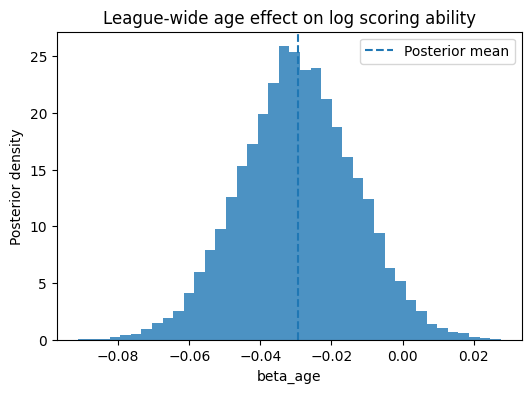

beta_age mean = -0.030
beta_age sd   = 0.016


In [ ]:
# Quick look at the age effect beta_age
beta_age_samps = np.array(samples_age["beta_age"])
mu_samps = np.array(samples_age["mu"])
tau_samps = np.array(samples_age["tau"])

plt.figure()
plt.hist(beta_age_samps, bins=40, density=True, alpha=0.8)
plt.axvline(beta_age_samps.mean(), linestyle="--", label="Posterior mean")
plt.xlabel("beta_age")
plt.ylabel("Posterior density")
plt.title("League-wide age effect on log scoring ability")
plt.legend()
plt.show()

print(f"beta_age mean = {beta_age_samps.mean():.3f}")
print(f"beta_age sd   = {beta_age_samps.std():.3f}")


In [ ]:
log_rate_samples = np.array(samples_age["log_rate"])  # shape: (n_samples, n_players)
n_players = df_prem.shape[0]

def show_player_age(idx=0):
    idx = int(idx)
    player = df_prem.loc[idx]

    log_rate_i = log_rate_samples[:, idx]
    rate_i = np.exp(log_rate_i)  # latent non-penalty goals per 90

    obs_npG_90 = player["npG_90_obs"]

    plt.figure()
    plt.hist(rate_i, bins=40, density=True, alpha=0.8)
    if not np.isnan(obs_npG_90):
        plt.axvline(obs_npG_90, linestyle="--", label="Observed npG/90 (raw)")
    plt.xlabel("Latent ability λ_i (non-penalty goals per 90)")
    plt.ylabel("Posterior density")
    plt.title(f"{player['Player']} ({player['Team']}), age {player['Age']:.0f}")
    plt.legend()
    plt.show()

    print(f"""Player: {player['Player']} ({player['Team']})
  Position           : {player['Pos']}
  Age                : {player['Age']:.0f}
  Minutes            : {player['Min']:.0f}
  Non-penalty goals  : {player['G_nopen']:.0f}
  Observed npG/90    : {obs_npG_90:.3f}
  Posterior λ mean   : {rate_i.mean():.3f}
  Posterior λ std    : {rate_i.std():.3f}
""")

widgets.interact(
    show_player_age,
    idx=widgets.IntSlider(value=0, min=0, max=n_players-1, step=1, description="Player idx")
);


interactive(children=(IntSlider(value=0, description='Player idx', max=352), Output()), _dom_classes=('widget-…

In [ ]:
import seaborn as sns

# ---- add Georgia Mraz ----
georgia = {
    "Player": "Georgia Mraz",
    "Min": 1485,                  # 120 minutes
    "Gls": 1,                    # 1 non-penalty goal (simplify)
    "Age": 18
}
df_georgia = pd.DataFrame([georgia])


df_georgia["G_nopen"] = df_georgia["Gls"].astype(float)
df_georgia["90s"] = df_georgia["Min"] / 90.0
df_georgia["npG_90_obs"] = df_georgia["G_nopen"] / df_georgia["90s"]

# match columns to df_prem
df_augmented = pd.concat([df_prem, df_georgia], ignore_index=True)

# prepare augmented data for the model
goals_aug = jnp.array(df_augmented["G_nopen"].values)
exposure_aug = jnp.array(df_augmented["90s"].values)
age_aug = jnp.array(df_augmented["Age"].values.astype(float))

# ---- re-run NumPyro sampling including Georgia
rng_key_aug = random.PRNGKey(2027)
kernel_aug = NUTS(prem_goal_model_age)
mcmc_aug = MCMC(kernel_aug, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc_aug.run(rng_key_aug, goals=goals_aug, exposure=exposure_aug, age=age_aug)

samples_aug = mcmc_aug.get_samples()

# ---- extract Georgia's latent ability ----
idx_georgia = df_augmented.index[df_augmented["Player"] == "Georgia Mraz"][0]

log_rate_aug = np.array(samples_aug["log_rate"])       # (n_samples, n_players)
georgia_samples = log_rate_aug[:, idx_georgia]
georgia_lambda = np.exp(georgia_samples)               # latent npG/90 for Georgia
lambda_aug_all = np.exp(log_rate_aug)                  # all players


sample: 100%|██████████| 3000/3000 [00:05<00:00, 517.29it/s, 15 steps of size 3.43e-01. acc. prob=0.81]


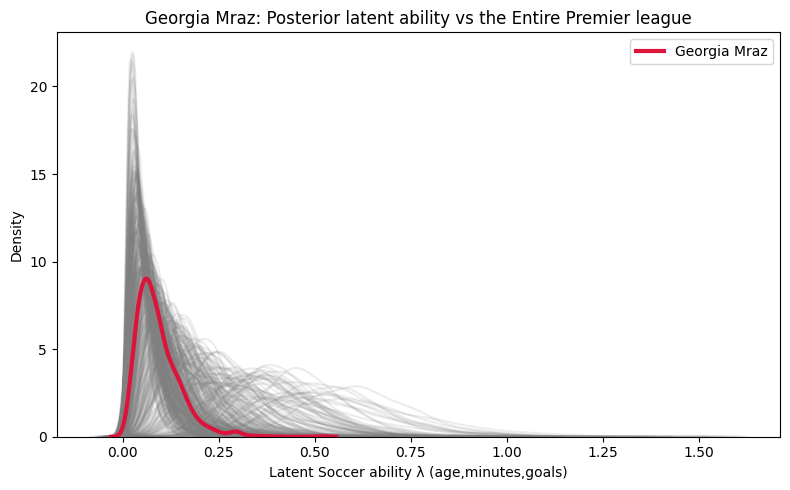

In [ ]:
# Georgia vs league distribution
plt.figure(figsize=(8, 5))

for i in range(lambda_aug_all.shape[1]):
    if i != idx_georgia:
        sns.kdeplot(lambda_aug_all[:, i], color="gray", alpha=0.15)

sns.kdeplot(georgia_lambda, color="crimson", lw=3, label="Georgia Mraz")
plt.xlabel("Latent Soccer ability λ (age,minutes,goals)")
plt.title("Georgia Mraz: Posterior latent ability vs the Entire Premier league")
plt.legend()
plt.tight_layout()
plt.show()


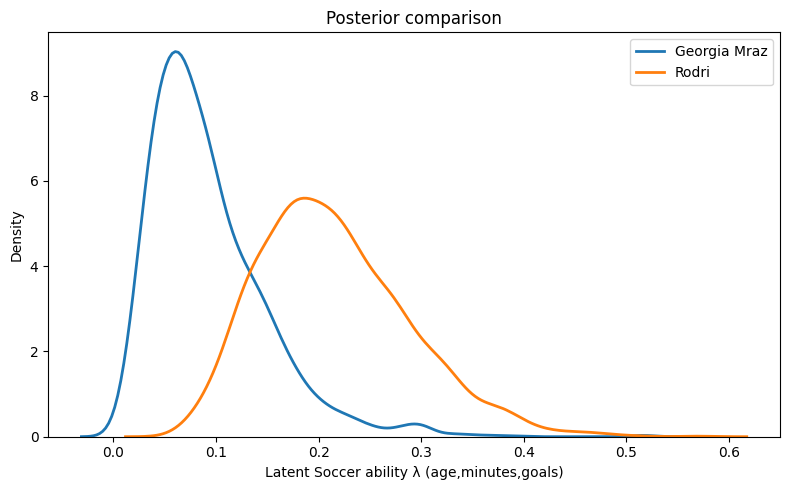

In [ ]:

compare_to = "Rodri"   # make sure this matches exactly a name in df_augmented

if compare_to in df_augmented["Player"].values:
    idx_compare = df_augmented.index[df_augmented["Player"] == compare_to][0]
    samples_compare = lambda_aug_all[:, idx_compare]

    plt.figure(figsize=(8, 5))
    sns.kdeplot(georgia_lambda, label="Georgia Mraz", lw=2)
    sns.kdeplot(samples_compare, label=compare_to, lw=2)
    plt.xlabel("Latent Soccer ability λ (age,minutes,goals)")
    plt.title("Posterior comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Player '{compare_to}' not found in df_augmented['Player'].unique()")


### 1.3 Soccer model: diagnostics and regression-style view

We now:

1. Convert the NumPyro run into an ArviZ `InferenceData` object.  
2. Show **trace plots** and a **posterior summary** for the population hyperparameters.  
3. Visualize the **population regression** of age ↦ goal-scoring ability.  
4. Make an **“apples to apples”** comparison plot:  
   - x-axis = latent ability (posterior mean λᵢ, with error bars)  
   - y-axis = observed non-penalty goals per 90, with approximate error bars from Poisson variability.


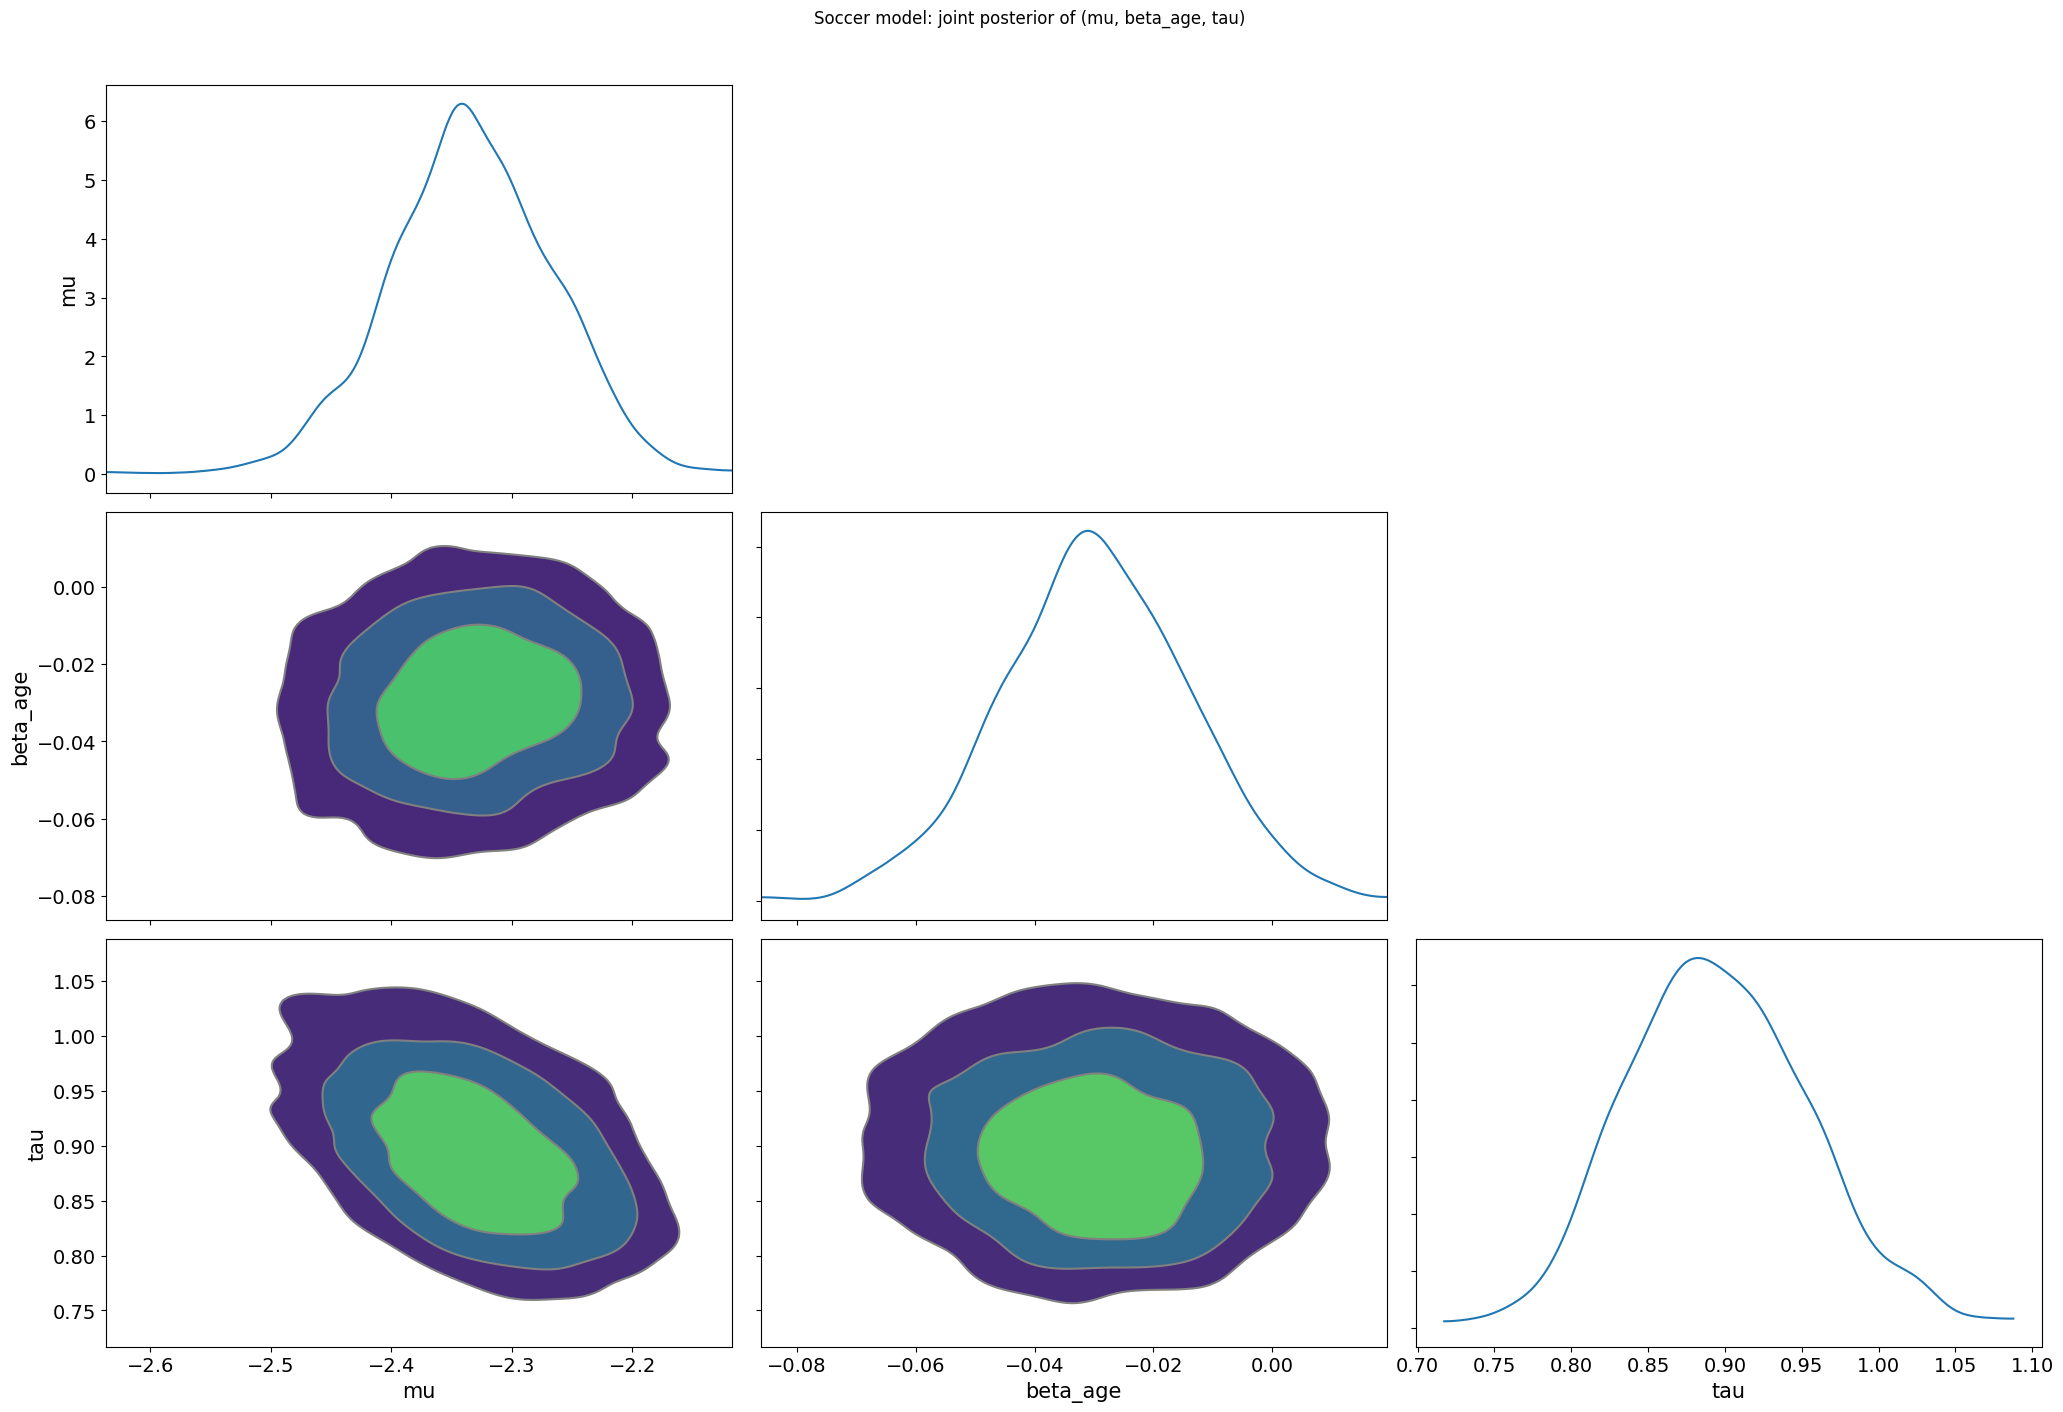

In [ ]:
# Pair / corner plot for soccer hyperparameters
az.plot_pair(
    idata_soccer,
    var_names=["mu", "beta_age", "tau"],
    kind="kde",          # smooth contours
    marginals=True,      # show 1D marginals on the diagonal
    divergences=False    # set True if you want to highlight divergences
)
plt.suptitle("Soccer model: joint posterior of (mu, beta_age, tau)", y=1.02)
plt.tight_layout()
plt.show()


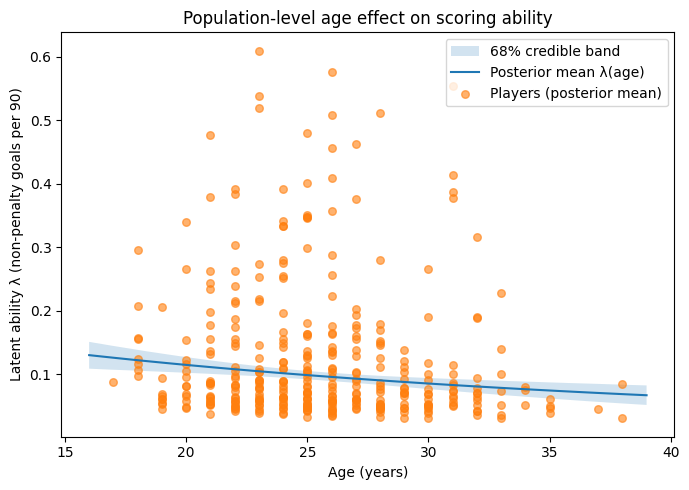

In [ ]:
# Use posterior samples to build a regression curve of age -> expected λ (goals per 90)

beta_age_samps = np.array(samples_age["beta_age"])
mu_samps = np.array(samples_age["mu"])

age_vals = df_prem["Age"].values.astype(float)
age_mean = age_vals.mean()

# Grid of ages for plotting (a bit beyond observed range)
age_grid = np.linspace(age_vals.min() - 1, age_vals.max() + 1, 100)

# For each posterior draw, compute λ(age) on the grid
# log λ(age) = mu + beta_age * (age - mean_age)
lambda_grid_samples = []
for mu_i, b_i in zip(mu_samps, beta_age_samps):
    log_lambda_g = mu_i + b_i * (age_grid - age_mean)
    lambda_grid_samples.append(np.exp(log_lambda_g))

lambda_grid_samples = np.stack(lambda_grid_samples, axis=0)  # (n_samples, n_grid)

lambda_mean = lambda_grid_samples.mean(axis=0)
lambda_low  = np.percentile(lambda_grid_samples, 16, axis=0)
lambda_high = np.percentile(lambda_grid_samples, 84, axis=0)

plt.figure(figsize=(7, 5))
# Population regression band
plt.fill_between(age_grid, lambda_low, lambda_high, alpha=0.2, label="68% credible band")
plt.plot(age_grid, lambda_mean, label="Posterior mean λ(age)")

# Overlay players (posterior mean) at their ages
log_rate_mean_per_player = log_rate_samples.mean(axis=0)
lambda_mean_per_player = np.exp(log_rate_mean_per_player)

plt.scatter(age_vals, lambda_mean_per_player, alpha=0.6, s=30, label="Players (posterior mean)")

plt.xlabel("Age (years)")
plt.ylabel("Latent ability λ (non-penalty goals per 90)")
plt.title("Population-level age effect on scoring ability")
plt.legend()
plt.tight_layout()
plt.show()


## Soccer shrinkage: low-minutes subs vs 90-minute workhorses

Instead of baseball, we can see Bayesian shrinkage **directly in soccer**.

For each Premier League player, we have:

- non-penalty goals $y_i$
- exposure in 90-minute units $E_i$
- observed non-penalty goals per 90:
  $$
  \text{npG/90}_i = \frac{y_i}{E_i}
  $$

Our Hierarchical model infers a **latent scoring ability**
\\( \lambda_i \\) (true non-penalty goals per 90), with
\\( \log \lambda_i \\) partially pooled through a league-wide prior.

Intuition:

- Players with **very few minutes** (sporadic subs) have noisy npG/90  
  → their abilities are shrunk strongly toward the league distribution.
- Players with **lots of minutes** (90-minute workhorses) have stable npG/90  
  → their posterior \\( \lambda_i \\) stays close to their observed rate.

We can visualize this by:

- putting **observed npG/90 on the x-axis**,  
- putting **posterior mean \\( \lambda_i \\) on the y-axis**, and  
- drawing arrows from the raw stat up/down to the shrunk posterior.

Coloring points by minutes played makes the shrinkage pattern obvious.


In [ ]:
# Use df_prem and log_rate_samples from the earlier soccer model

# Compute posterior mean λ_i for each player
log_rate_mean_per_player = log_rate_samples.mean(axis=0)
lambda_post_mean = np.exp(log_rate_mean_per_player)

df_prem["lambda_post_mean"] = lambda_post_mean

# Observed non-penalty goals per 90
obs_npG_90 = df_prem["npG_90_obs"].values

# Define minutes groups: "low" vs "high"
minutes = df_prem["Min"].values

# You can tweak these thresholds for your talk
low_cut  = 900    # ≤ 10 full matches
high_cut = 2000   # ≥ ~22 full matches

group = np.full(len(df_prem), "mid", dtype=object)
group[minutes <= low_cut] = "low-minutes"
group[minutes >= high_cut] = "workhorse"

df_prem["minutes_group"] = group


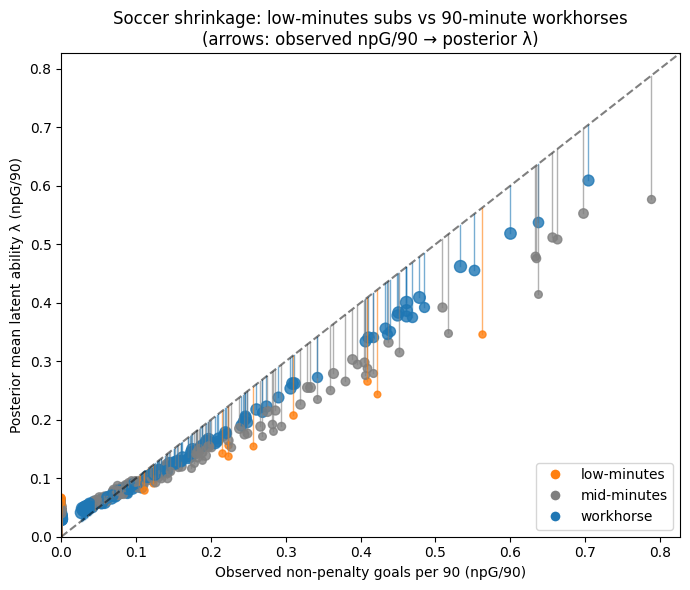

In [ ]:
plt.figure(figsize=(7, 6))

for i, row in df_prem.iterrows():
    x = row["npG_90_obs"]          # observed npG/90
    y = row["lambda_post_mean"]    # posterior latent λ
    mins = row["Min"]
    g = row["minutes_group"]

    if np.isnan(x):
        continue

    # Color by minutes group
    if g == "low-minutes":
        color = "tab:orange"
    elif g == "workhorse":
        color = "tab:blue"
    else:
        color = "tab:gray"

    # Vertical arrow: observed -> posterior
    plt.plot([x, x], [x, y], color=color, alpha=0.6, linewidth=1)

    # Marker size scales with minutes
    size = 10 + 0.02 * mins
    plt.scatter(x, y, s=size, color=color, alpha=0.8)

# Reference line: no shrinkage
lims = [0.0, max(0.6, float(np.nanmax(obs_npG_90) * 1.05))]
plt.plot(lims, lims, "k--", alpha=0.5, label="No shrinkage (posterior = observed)")

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Observed non-penalty goals per 90 (npG/90)")
plt.ylabel("Posterior mean latent ability λ (npG/90)")
plt.title("Soccer shrinkage: low-minutes subs vs 90-minute workhorses\n(arrows: observed npG/90 → posterior λ)")
low_patch  = plt.Line2D([0], [0], marker="o", color="w",
                        markerfacecolor="tab:orange", label="low-minutes", markersize=8)
high_patch = plt.Line2D([0], [0], marker="o", color="w",
                        markerfacecolor="tab:blue", label="workhorse", markersize=8)
mid_patch  = plt.Line2D([0], [0], marker="o", color="w",
                        markerfacecolor="tab:gray", label="mid-minutes", markersize=8)
plt.legend(handles=[low_patch, mid_patch, high_patch], loc="lower right")
plt.tight_layout()
plt.show()


## 2. Baseball: Hierarchical Batting Averages

We now switch to a **simulated baseball** example to show the same ideas in a simpler setting.

- Each player has a latent batting average $\theta_i$.
- The league has a population-level mean and concentration.
- We observe hits / at-bats and infer $\theta_i$ using a **Beta–Binomial** hierarchical model.

This is perfect for visualizing **shrinkage**:
players with few at-bats get pulled harder towards the league mean.


In [ ]:
# Make shrinkage really visible: many rookies (few AB) + a few veterans (lots of AB)

n_rookies = 20
n_vets = 10
n_players_bb = n_rookies + n_vets

true_league_mean = 0.27
true_league_kappa = 80.0

alpha_true = true_league_mean * true_league_kappa
beta_true  = (1 - true_league_mean) * true_league_kappa

# Draw true abilities for all players
theta_true = rng.beta(alpha_true, beta_true, size=n_players_bb)

# Rookies: few AB, very noisy
at_bats_rookies = rng.integers(5, 30, size=n_rookies)

# Veterans: many AB, more stable
at_bats_vets = rng.integers(250, 600, size=n_vets)

at_bats = np.concatenate([at_bats_rookies, at_bats_vets])

# Observed hits from Binomial
hits = rng.binomial(at_bats, theta_true)

df_baseball = pd.DataFrame({
    "player_id": np.arange(n_players_bb),
    "at_bats": at_bats,
    "hits": hits,
    "obs_avg": np.where(at_bats > 0, hits / at_bats, np.nan),
    "theta_true": theta_true,
})
df_baseball["type"] = ["rookie"] * n_rookies + ["vet"] * n_vets

df_baseball.sort_values("at_bats").reset_index(drop=True)


,player_id,at_bats,hits,obs_avg,theta_true,type
0,9,6,2,0.333333,0.285148,rookie
1,2,7,2,0.285714,0.245764,rookie
2,5,7,1,0.142857,0.231280,rookie
3,17,7,0,0.000000,0.232978,rookie
4,15,8,3,0.375000,0.275092,rookie
5,0,8,0,0.000000,0.261924,rookie
6,10,9,2,0.222222,0.334103,rookie
7,12,9,3,0.333333,0.287205,rookie
8,18,9,2,0.222222,0.236580,rookie
9,13,13,4,0.307692,0.321953,rookie


In [ ]:
with pm.Model() as baseball_model:
    # Population-level
    mu = pm.Beta("mu", alpha=1.0, beta=1.0)
    kappa = pm.HalfNormal("kappa", sigma=50.0)

    alpha_pop = pm.Deterministic("alpha_pop", mu * kappa)
    beta_pop  = pm.Deterministic("beta_pop", (1 - mu) * kappa)

    # Player-level abilities
    theta = pm.Beta("theta", alpha=alpha_pop, beta=beta_pop, shape=n_players_bb)

    # Observations
    y = pm.Binomial("y", n=at_bats, p=theta, observed=hits)

    trace_bb = pm.sample(
        draws=2000,
        tune=1500,
        target_accept=0.9,
        random_seed=123,
        cores=1,
        return_inferencedata=True
    )


Output()

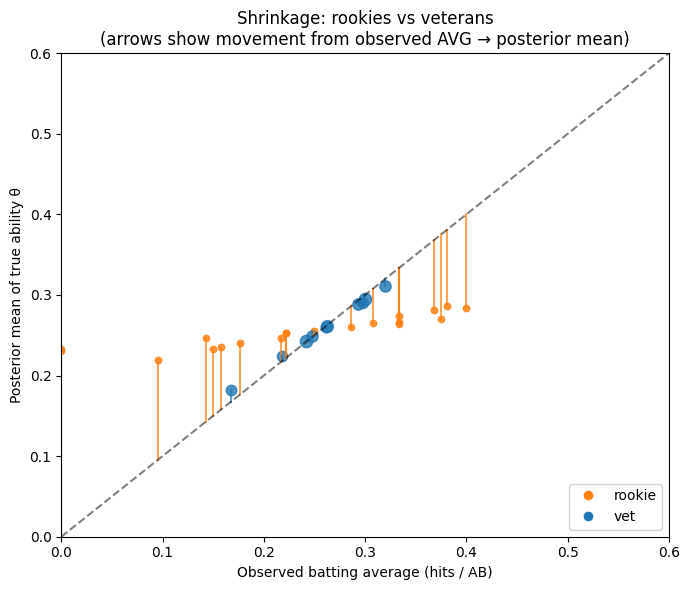

In [ ]:
# Stack posterior samples for theta_i
theta_samples = trace_bb.posterior["theta"].stack(sample=("chain", "draw")).values  # shape (player, samples)

# Posterior mean for each player
theta_post_mean = theta_samples.mean(axis=1)

df_baseball["theta_post_mean"] = theta_post_mean

plt.figure(figsize=(7, 6))

for i, row in df_baseball.iterrows():
    x = row["obs_avg"]
    y = row["theta_post_mean"]
    ab = row["at_bats"]
    color = "tab:orange" if row["type"] == "rookie" else "tab:blue"

    # Arrow from observed avg (x,x) to shrunk posterior mean (x,y)
    plt.plot([x, x], [x, y], color=color, alpha=0.7)
    plt.scatter(x, y, s=20 + ab * 0.1, color=color, alpha=0.8)  # bigger marker = more AB

# Reference line: no shrinkage (posterior = observed)
lims = [0.0, 0.6]
plt.plot(lims, lims, "k--", alpha=0.5, label="No shrinkage line (posterior = observed)")

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Observed batting average (hits / AB)")
plt.ylabel("Posterior mean of true ability θ")
plt.title("Shrinkage: rookies vs veterans\n(arrows show movement from observed AVG → posterior mean)")
rookie_patch = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="tab:orange", label="rookie", markersize=8)
vet_patch = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="tab:blue", label="vet", markersize=8)
plt.legend(handles=[rookie_patch, vet_patch], loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
# Sort by at-bats to see extremes
df_baseball_sorted = df_baseball.sort_values("at_bats")
df_baseball_sorted[["player_id", "type", "at_bats", "hits", "obs_avg", "theta_post_mean"]].head(10)


,player_id,type,at_bats,hits,obs_avg,theta_post_mean
9,9,rookie,6,2,0.333333,0.264452
2,2,rookie,7,2,0.285714,0.260095
5,5,rookie,7,1,0.142857,0.246860
17,17,rookie,7,0,0.000000,0.232358
15,15,rookie,8,3,0.375000,0.270036
0,0,rookie,8,0,0.000000,0.229971
10,10,rookie,9,2,0.222222,0.252541
12,12,rookie,9,3,0.333333,0.265934
18,18,rookie,9,2,0.222222,0.253340
13,13,rookie,13,4,0.307692,0.265360


## Toy level Exoplanet Mass–Metallicity Model.

#### (For the full model HERMES package. Contact Wasi Naqvi)

Finally, we build a **toy exoplanet model** that echoes the HERMES idea:

- Simulate planets with log mass log M.  
- Assume a true linear trend between log M and log metallicity.  
- Add **intrinsic scatter** and **heteroskedastic measurement noise**.  
- Infer the population hyperparameters \\(\\alpha\\), \\(\\beta\\), \\(\\sigma_{\\rm int}\\) with a hierarchical model.

This is the planetary-astrophysics analog of the striker/baseball stories.


In [ ]:
def simulate_exoplanets(N=40, sigma_intrinsic=0.2, sigma_meas_scale=0.1):
    logM = rng.uniform(-1.0, 2.0, size=N)
    logM_centered = logM - logM.mean()

    alpha_true = -3.0
    beta_true  = 0.7

    Z_true = alpha_true + beta_true * logM_centered \
             + rng.normal(0, sigma_intrinsic, size=N)

    sigma_obs = rng.uniform(0.3 * sigma_meas_scale,
                            1.7 * sigma_meas_scale,
                            size=N)
    Z_obs = Z_true + rng.normal(0, sigma_obs)

    return {
        "logM": logM,
        "logM_centered": logM_centered,
        "Z_true": Z_true,
        "Z_obs": Z_obs,
        "sigma_obs": sigma_obs,
        "alpha_true": alpha_true,
        "beta_true": beta_true,
        "sigma_intrinsic_true": sigma_intrinsic
    }

def exoplanet_model(logM_centered, Z_obs, sigma_obs):
    alpha = numpyro.sample("alpha", dist.Normal(-3.0, 1.0))
    beta  = numpyro.sample("beta", dist.Normal(0.0, 1.0))
    sigma_int = numpyro.sample("sigma_int", dist.HalfNormal(0.5))

    mu = alpha + beta * logM_centered

    with numpyro.plate("planet", logM_centered.shape[0]):
        Z_true = numpyro.sample("Z_true", dist.Normal(mu, sigma_int))
        numpyro.sample("Z_obs", dist.Normal(Z_true, sigma_obs), obs=Z_obs)


In [ ]:
def run_exoplanet_demo(N=40, sigma_intrinsic=0.2, sigma_meas_scale=0.1):
    sim = simulate_exoplanets(
        N=int(N),
        sigma_intrinsic=float(sigma_intrinsic),
        sigma_meas_scale=float(sigma_meas_scale)
    )

    logM_c = jnp.array(sim["logM_centered"])
    Z_obs  = jnp.array(sim["Z_obs"])
    sigma_obs = jnp.array(sim["sigma_obs"])

    rng_key = random.PRNGKey(0)
    kernel = NUTS(exoplanet_model)
    mcmc = MCMC(kernel, num_warmup=800, num_samples=1200, num_chains=1)
    mcmc.run(rng_key, logM_centered=logM_c, Z_obs=Z_obs, sigma_obs=sigma_obs)
    samples = mcmc.get_samples()

    alpha_s = np.array(samples["alpha"])
    beta_s  = np.array(samples["beta"])
    sigma_int_s = np.array(samples["sigma_int"])

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))

    ax0 = ax[0]
    ax0.errorbar(sim["logM"], Z_obs, yerr=sigma_obs, fmt="o", alpha=0.7, label="Data")
    xs = np.linspace(sim["logM"].min(), sim["logM"].max(), 100)
    xs_c = xs - sim["logM"].mean()

    step = max(1, len(alpha_s)//60)
    for i in range(0, len(alpha_s), step):
        y_line = alpha_s[i] + beta_s[i] * xs_c
        ax0.plot(xs, y_line, lw=0.5, alpha=0.2)

    true_line = sim["alpha_true"] + sim["beta_true"] * xs_c
    ax0.plot(xs, true_line, lw=2, label="True relation")

    ax0.set_xlabel("log M")
    ax0.set_ylabel("log (metallicity)")
    ax0.set_title("Toy exoplanet mass–metallicity relation")
    ax0.legend()

    ax1 = ax[1]
    ax1.hist(beta_s, bins=40, density=True, alpha=0.8)
    ax1.axvline(sim["beta_true"], linestyle="--", label="True beta")
    ax1.set_xlabel("beta (slope)")
    ax1.set_ylabel("Posterior density")
    ax1.set_title("Posterior of beta")
    ax1.legend()

    plt.tight_layout()
    plt.show()

    print(f"True alpha: {sim['alpha_true']:.2f}")
    print(f"Posterior alpha: mean={alpha_s.mean():.2f}, sd={alpha_s.std():.2f}")
    print(f"True beta: {sim['beta_true']:.2f}")
    print(f"Posterior beta: mean={beta_s.mean():.2f}, sd={beta_s.std():.2f}")
    print(f"True sigma_int: {sim['sigma_intrinsic_true']:.2f}")
    print(f"Posterior sigma_int: mean={sigma_int_s.mean():.2f}, sd={sigma_int_s.std():.2f}")

widgets.interact(
    run_exoplanet_demo,
    N=widgets.IntSlider(value=40, min=10, max=200, step=10, description="N planets"),
    sigma_intrinsic=widgets.FloatSlider(value=0.2, min=0.05, max=0.6, step=0.05,
                                        description="sigma_intrinsic"),
    sigma_meas_scale=widgets.FloatSlider(value=0.1, min=0.05, max=0.5, step=0.05,
                                         description="sigma_meas_scale")
);


interactive(children=(IntSlider(value=40, description='N planets', max=200, min=10, step=10), FloatSlider(valu…

### 3.2 Exoplanet model: pair plot of hyperparameters

We now visualize the joint posterior of the exoplanet hyperparameters:

- $\alpha$ – intercept  
- $\beta$ – slope between metallicity and log mass  
- $\sigma_{\text{int}}$ – intrinsic scatter  

This gives a corner plot that matches the soccer plot style,
making the analogy between the two hierarchical models visually immediate.


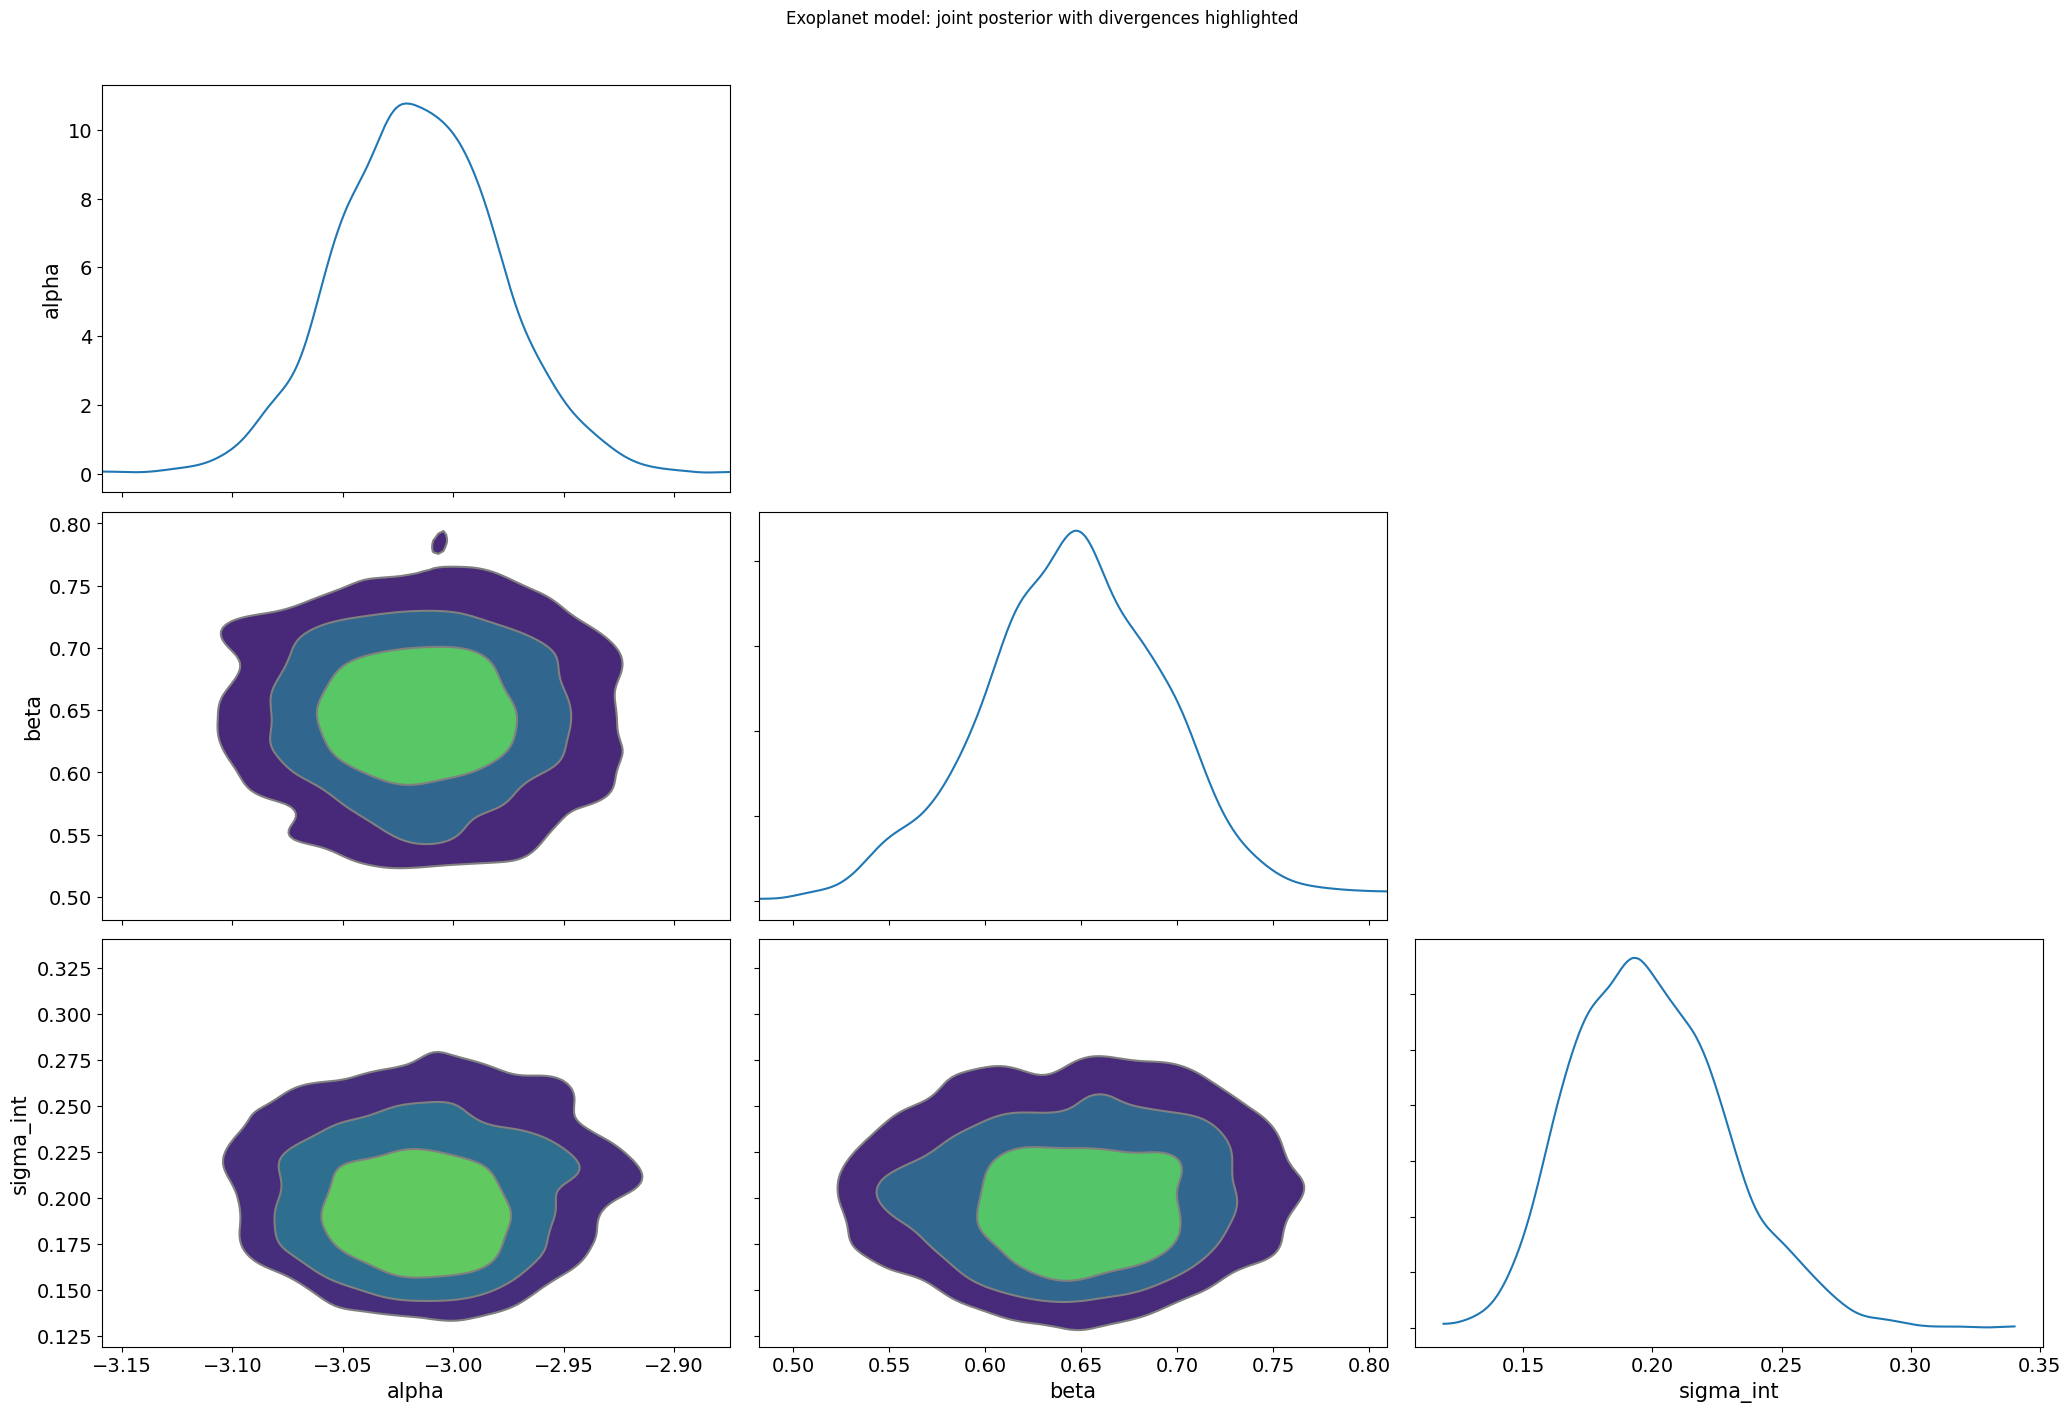

In [ ]:
az.plot_pair(
    idata_exo,
    var_names=["alpha", "beta", "sigma_int"],
    kind="kde",
    marginals=True,
    divergences=True   # divergent draws get marked in red
)
plt.suptitle("Exoplanet model: joint posterior with divergences highlighted", y=1.02)
plt.tight_layout()
plt.show()


# The Final Boss of the Notebook

## Line–intensity mapping: stacking voxels with a hierarchical model (Courtesy Patrick Horlaville)

Time for a slightly more “cosmological” example. I took this example from Patrick who was kind enough to explain it to me.

Picture a line–intensity map (LIM): for each voxel in an $x \times y \times z$ cube
we measure a line intensity as a function of redshift. Each voxel is really a
**mixture of many galaxies**, but we only see their combined line signal plus noise.

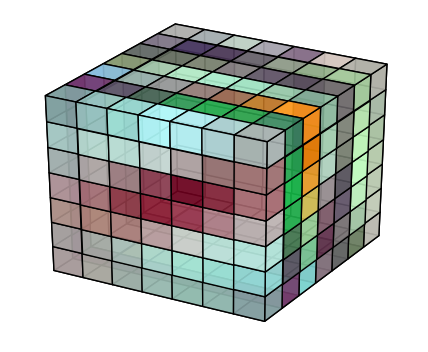


Different **populations of galaxies** (e.g. star–forming vs quiescent, elliptical , different halo
mass bins, whatever your favourite taxonomy is. I really dont know much about galaxies) have different *typical* line
intensities. If we label which population each voxel “belongs” to, we can try to
infer:

- the **population–level mean line intensities**, and
- the underlying **global distribution** those population means come from.

This screams “Bayesian hierarchical model”.

We’ll do the following toy experiment:

1. Define a small number of **galaxy populations**, each with a true mean line
   intensity drawn from a hyper–distribution.
2. Tile an $(N_x \times N_y \times N_z $ voxel cube and assign each voxel to one of
   these populations.
3. For each voxel, generate a **mock line–intensity measurement** with Gaussian
   noise and an associated uncertainty (so this looks like a line intensity map
   at some redshift slice).
4. Fit a **hierarchical Gaussian model** where each population’s mean intensity
   is drawn from a global distribution.
5. Show **Bayesian shrinkage**: noisy populations get pulled toward the global
   mean when we “restack” them using the posterior, instead of the raw voxel
   averages.

This is exactly the same kind of partial pooling as in the soccer example, but
now the “players” are galaxy populations and the “goals” are line intensities in
voxels.


### 4.3 Hierarchical Gaussian model for line intensities

We now promote the population means to *random variables* drawn from a
population-level distribution.

Let

- \\(k = 1, \dots, K\\) index galaxy populations,
- \\(i = 1, \dots, N\\) index voxels.

For each voxel we know:

- which population it belongs to: \\( \text{pop}_i \\),
- its observed intensity \\( I_i^{\text{obs}} \\),
- an observational uncertainty \\( \sigma_i \\).

We posit:

Global (hyper) parameters:

$$
\mu \sim \mathcal{N}(0, 2^2), \qquad
\tau \sim \text{HalfNormal}(1)
$$

Population-level means:

$$
\theta_k \sim \mathcal{N}(\mu,\; \tau^2)
$$

Voxel-level observations:

$$
I_i^{\text{obs}} \sim \mathcal{N}(\theta_{\text{pop}_i},\; \sigma_i^2)
$$

So each population mean \\( \theta_k \\) is shrunk toward the global mean \\( \mu \\),
and each voxel only “nudges” its population mean according to its own noise
level. Populations with **few, noisy voxels** get pulled strongly toward \\( \mu \\);
populations supported by **many clean voxels** stay close to their naive mean.



Let’s build a toy universe:

- There are \\(K=3\\) galaxy populations.
- Each population has a true mean line intensity \\(\\theta_k\\) and a common
  intrinsic scatter \\(\\sigma_{\\text{int}}\\).
- We draw many voxels, each secretly belonging to one of the \\(K\\) populations,
  then add Gaussian noise.

We, the poor observers, only see:

- a 1D cloud of intensities \\(I_i^{\text{obs}}\\),
- and maybe an idea of the measurement noise.

In a line–intensity map you often just get **one number per voxel**:
a noisy line intensity at some redshift. Under the hood, that voxel is a
mixture of different galaxy populations — but you don’t get a label that says
“this one is from star–forming dwarfs, this one is from quiescent monsters”.

We will:

1. **Generate** mock data from three Gaussians and plot those “true” line–intensity
   curves.
2. Fit a **single Gaussian** (naive stacking) and see how it blurs everything.
3. Fit a **Bayesian hierarchical mixture**:

   - mixture weights \\(w_k\\),
   - component means \\(\\theta_k\\) drawn from a hyper–prior,
   - shared scatter.

   The component means share information via a global hyper–mean and hyper–spread.
4. Overlay the **recovered Gaussians** on the true ones. This is “Bayesian stacking”:
   we’ve let the model discover and restack the hidden populations instead of
   assuming everything is one blob.


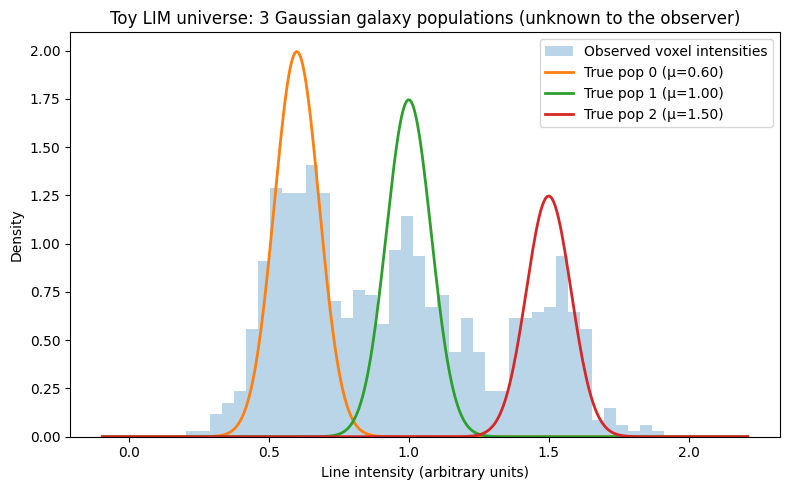

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

rng_mix = np.random.default_rng(321)

# ---- 4.1 simulate a toy LIM universe with K Gaussian populations ----

K = 3  # number of galaxy populations

# true population means (line intensities) and intrinsic scatter
theta_true = np.array([0.6, 1.0, 1.5])          # arbitrary units
sigma_int_true = 0.08                           # intrinsic scatter within population
sigma_meas = 0.10                               # measurement noise (assume constant for simplicity)

# mixture weights. i.e how common each population is) !!!
w_true = np.array([0.4, 0.35, 0.25])

# number of voxels
N_vox = 800

# latent population for each voxel (this is never shown to the model)
z_true = rng_mix.choice(K, size=N_vox, p=w_true)

# draw "true" voxel intensities, then add measurement noise
intensity_true = rng_mix.normal(theta_true[z_true], sigma_int_true)
intensity_obs  = intensity_true + rng_mix.normal(0.0, sigma_meas, size=N_vox)

# small dataframe for convenience (we will NOT give z_true to the model)
df_mix = pd.DataFrame({
    "I_true": intensity_true,
    "I_obs": intensity_obs,
    "z_true": z_true
})

# plot
x_grid = np.linspace(intensity_obs.min() - 0.3, intensity_obs.max() + 0.3, 400)

plt.figure(figsize=(8, 5))
plt.hist(intensity_obs, bins=40, density=True, alpha=0.3, label="Observed voxel intensities")

# true component PDFs (intrinsic only, not convolved with measurement noise)
for k in range(K):
    pdf_k = w_true[k] * norm.pdf(x_grid, loc=theta_true[k], scale=sigma_int_true)
    plt.plot(x_grid, pdf_k, lw=2, label=f"True pop {k} (μ={theta_true[k]:.2f})")

plt.xlabel("Line intensity (arbitrary units)")
plt.ylabel("Density")
plt.title("Toy LIM universe: 3 Gaussian galaxy populations (unknown to the observer)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC

# data as jnp arrays
y_obs = jnp.array(df_vox["intensity_obs"].values)
sigma_obs_j = jnp.array(df_vox["sigma_obs"].values)
pop_id_j = jnp.array(df_vox["pop_id"].values)
k_pop = len(np.unique(pop_id_j))

def lim_hier_model(y, sigma, pop_id):
    # hyperparameters
    mu = numpyro.sample("mu", dist.Normal(0.0, 2.0))
    tau = numpyro.sample("tau", dist.HalfNormal(1.0))

    # population-level means
    with numpyro.plate("pop", k_pop):
        theta = numpyro.sample("theta", dist.Normal(mu, tau))

    # voxel-level likelihood
    with numpyro.plate("voxel", y.shape[0]):
        mu_vox = theta[pop_id]
        numpyro.sample("y", dist.Normal(mu_vox, sigma), obs=y)

# run MCMC
rng_key_lim = random.PRNGKey(2025)
kernel_lim = NUTS(lim_hier_model)
mcmc_lim = MCMC(kernel_lim, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc_lim.run(rng_key_lim, y=y_obs, sigma=sigma_obs_j, pop_id=pop_id_j)

samples_lim = mcmc_lim.get_samples()
samples_lim.keys()


sample: 100%|██████████| 3000/3000 [00:05<00:00, 523.10it/s, 7 steps of size 5.58e-01. acc. prob=0.88]


dict_keys(['mu', 'tau', 'theta'])

### 4.2 Naive single–Gaussian stacking

If we stubbornly refuse to acknowledge that there might be multiple populations,
we can fit a **single Gaussian**:

$$
I_i^{\text{obs}} \sim \mathcal{N}(\mu_{\text{naive}},\; \sigma_{\text{naive}}^2).
$$

This is equivalent to taking all voxels, forgetting any notion of populations,
and “stacking” them into one grand average.

Unsurprisingly, this gives us a blurry, in–between profile that hides the real
structure in the data.


Naive Gaussian fit: mu = 0.957, sigma = 0.378


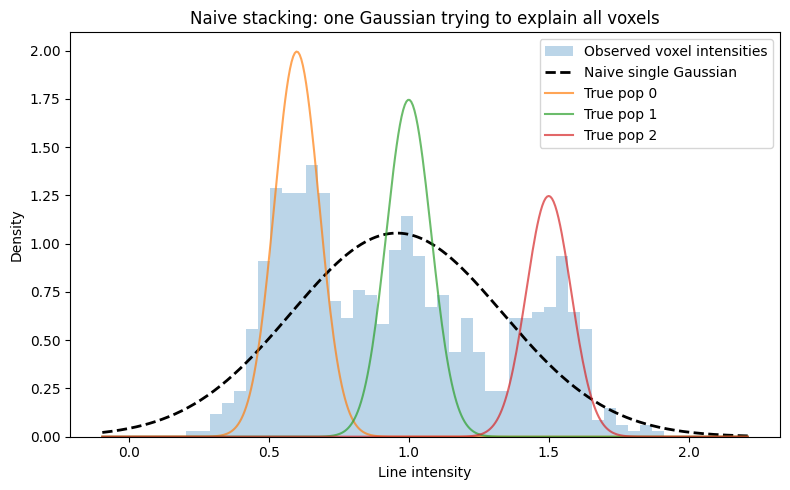

In [ ]:
# ---- 4.2 naive single-Gaussian "stacking" ----
mu_naive = intensity_obs.mean()
sigma_naive = intensity_obs.std(ddof=1)

print(f"Naive Gaussian fit: mu = {mu_naive:.3f}, sigma = {sigma_naive:.3f}")

plt.figure(figsize=(8, 5))
plt.hist(intensity_obs, bins=40, density=True, alpha=0.3, label="Observed voxel intensities")

pdf_naive = norm.pdf(x_grid, loc=mu_naive, scale=sigma_naive)
plt.plot(x_grid, pdf_naive, "k--", lw=2, label="Naive single Gaussian")

# overlay true components again for comparison
for k in range(K):
    pdf_k = w_true[k] * norm.pdf(x_grid, loc=theta_true[k], scale=sigma_int_true)
    plt.plot(x_grid, pdf_k, lw=1.5, alpha=0.7, label=f"True pop {k}")

plt.xlabel("Line intensity")
plt.ylabel("Density")
plt.title("Naive stacking: one Gaussian trying to explain all voxels")
plt.legend()
plt.tight_layout()
plt.show()


### 4.3 Bayesian hierarchical mixture model

Now we do something more honest.

We assume there might be **\(K\) Gaussian components**, but we do **not** know:

- which voxel came from which component (latent labels),
- the component means \(\theta_k\),
- or the mixture weights \(w_k\).

We set up a hierarchical Gaussian mixture:

**Hyper–priors:**

$\mu_{\text{global}} \sim \mathcal{N}(1.0,\; 0.5^2), \qquad
\tau \sim \text{HalfNormal}(0.5).$

**Component means:**

$
\theta_k \sim \mathcal{N}(\mu_{\text{global}},\; \tau^2),
\qquad k = 1,\dots,K.
$

**Mixture weights:**

$
\mathbf{w} \sim \text{Dirichlet}(1,1,\dots,1).
$

**Shared scatter (for simplicity):**

$
\sigma \sim \text{HalfNormal}(0.2).$

**Likelihood (marginalizing unknown component labels):**

$
I_i^{\text{obs}} \sim \sum_{k=1}^K
w_k \, \mathcal{N}(\theta_k,\; \sigma^2).
$

We never tell the model which voxel came from which population.
It infers that structure **purely from the 1D cloud of intensities**.

This is a **Bayesian hierarchical mixture model**:
the $\theta_k$ themselves live in a population
and the mixture lets us “cluster’’ voxels into **latent galaxy populations**.


In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as lim_mix_model:
    # hyper-priors for component means
    mu_global = pm.Normal("mu_global", mu=1.0, sigma=0.5)
    tau = pm.HalfNormal("tau", sigma=0.5)

    # component means (hierarchical)
    mu_k = pm.Normal("mu_k", mu=mu_global, sigma=tau, shape=K)

    # shared scatter
    sigma = pm.HalfNormal("sigma", sigma=0.2)

    # mixture weights
    w = pm.Dirichlet("w", a=np.ones(K))

    # component distributions (vectorized)
    comp_dists = pm.Normal.dist(mu=mu_k, sigma=sigma)

    # mixture likelihood (marginalizing component labels)
    y = pm.Mixture("y", w=w, comp_dists=comp_dists, observed=intensity_obs)

    trace_lim = pm.sample(
        draws=2000,
        tune=1500,
        target_accept=0.9,
        random_seed=123,
        cores=1,
        return_inferencedata=True
    )

az.summary(trace_lim, var_names=["mu_global", "tau", "mu_k", "sigma", "w"])


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_global,1.034,0.251,0.540,1.479,0.004,0.005,4868.0,2189.0,1.00
tau,0.501,0.194,0.209,0.859,0.003,0.004,4787.0,3015.0,1.00
mu_k[0],0.611,0.009,0.594,0.628,0.000,0.000,5264.0,2985.0,1.00
mu_k[1],1.261,0.239,1.005,1.517,0.168,0.000,3.0,55.0,1.83
mu_k[2],1.261,0.239,1.004,1.517,0.169,0.000,3.0,50.0,1.83
sigma,0.129,0.004,0.121,0.137,0.000,0.000,5913.0,2798.0,1.00
w[0],0.441,0.020,0.402,0.477,0.000,0.000,4265.0,3351.0,1.00
w[1],0.279,0.039,0.216,0.340,0.025,0.000,3.0,49.0,1.81
w[2],0.279,0.039,0.221,0.346,0.025,0.000,3.0,49.0,1.81


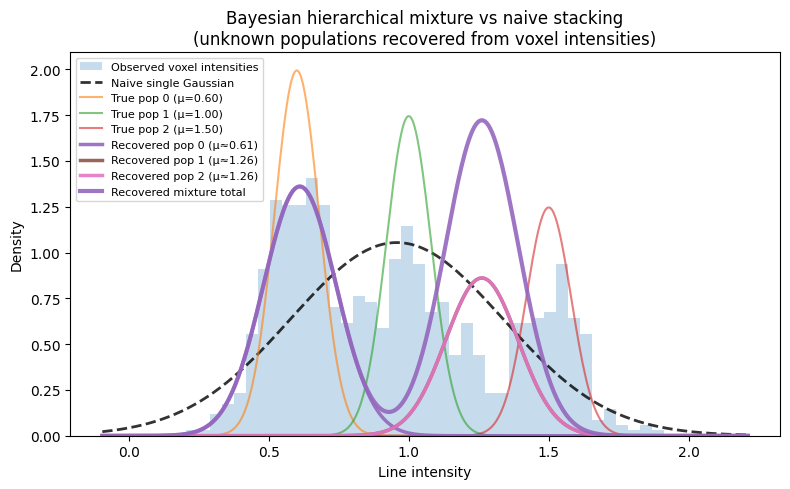

In [ ]:
# ---- 4.4 plot recovered mixture vs true populations and naive Gaussian ----

# posterior means
mu_k_samps = trace_lim.posterior["mu_k"].values  # (chain, draw, K)
w_samps = trace_lim.posterior["w"].values        # (chain, draw, K)
sigma_samps = trace_lim.posterior["sigma"].values

mu_k_post = mu_k_samps.mean(axis=(0, 1))         # (K,)
w_post = w_samps.mean(axis=(0, 1))               # (K,)
sigma_post = sigma_samps.mean(axis=(0, 1))       # scalar

plt.figure(figsize=(8, 5))
plt.hist(intensity_obs, bins=40, density=True, alpha=0.25, label="Observed voxel intensities")

# naive single Gaussian
pdf_naive = norm.pdf(x_grid, loc=mu_naive, scale=sigma_naive)
plt.plot(x_grid, pdf_naive, "k--", lw=2, alpha=0.8, label="Naive single Gaussian")

# true components
for k in range(K):
    pdf_true_k = w_true[k] * norm.pdf(x_grid, loc=theta_true[k], scale=sigma_int_true)
    plt.plot(x_grid, pdf_true_k, lw=1.5, alpha=0.6, label=f"True pop {k} (μ={theta_true[k]:.2f})")

# recovered components (posterior mean)
for k in range(K):
    pdf_post_k = w_post[k] * norm.pdf(x_grid, loc=mu_k_post[k], scale=sigma_post)
    plt.plot(x_grid, pdf_post_k, lw=2.5, alpha=0.9, label=f"Recovered pop {k} (μ≈{mu_k_post[k]:.2f})")

# overall recovered mixture
pdf_mix_post = np.zeros_like(x_grid)
for k in range(K):
    pdf_mix_post += w_post[k] * norm.pdf(x_grid, loc=mu_k_post[k], scale=sigma_post)

plt.plot(x_grid, pdf_mix_post, color="tab:purple", lw=3, alpha=0.9, label="Recovered mixture total")

plt.xlabel("Line intensity")
plt.ylabel("Density")
plt.title("Bayesian hierarchical mixture vs naive stacking\n(unknown populations recovered from voxel intensities)")
plt.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()
